In [1]:
import os , sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier


import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

import random

import optuna

random.seed(2020)
np.random.seed(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class Preprocessing:
    def __init__(self):
        self.porter = PorterStemmer()
        self.stop_words = get_stop_words('en')
        self.stop_words.append(' ')
        self.stop_words.append('')
    
    def pipeline(self, df):
        for lang in ['description']:
            #, 'translate_es', 'translate_fr', 'translate_de', 'translate_ja']:
            df[lang] = df[lang].apply(lambda x: self.change_text(x))
        return df

    def change_text(self, text):
        text = text.lower()
        text = text.replace('ml', 'machine learning')
        text = text.replace('machine learning', 'machinelearning')
        text = "".join([char if char not in string.punctuation else ' ' for char in text])
        text = " ".join([self.porter.stem(char) for char in text.split(' ') if char not in self.stop_words])
        return text
    
    def vectorize_tfidf(self, df):
        vec_tfidf = TfidfVectorizer()
        X = vec_tfidf.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names())
        return X
    
    def vectorize_cnt(self, df):
        vec_cnt = CountVectorizer()
        X = vec_cnt.fit_transform(df.description.values)
        X = pd.DataFrame(X.toarray(), columns=vec_cnt.get_feature_names())
        return X


class Optimize_by_Optuna:
    def __init__(self, data, features, target_colname, target_name_2=None, _objective=None):
        self.data = data
        self.features = features
        self.target = target_colname
        if not target_colname:
            self.target_2 = target_colname
        else:
            self.target_2 = target_name_2
        self._objective = _objective
        
    
    def make_score(self, y, preds):
        s_1=1 - metrics.accuracy_score(y, preds)
        s_2=list(self.model.best_score['valid_1'].values())[0]

        return (s_1+s_2)/2

    def objective(self, trial):
                        
        PARAMS = {#'boosting_type': 'gbdt', 'metric': 'rmse',
            'boosting_type': 'gbdt',
            
            #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
            
            'objective': 'tweedie','metric': 'tweedie',
            
            'n_estimators': 1400,
            'boost_from_average': False,'verbose': -1,'random_state':2020,
        

            'tweedie_variance_power': trial.suggest_uniform('tweedie_variance_power', 1.01, 1.8),


            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
            'subsample_freq': trial.suggest_uniform('subsample_freq', 0.4, 0.9),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.03, 0.5),
            'num_leaves': trial.suggest_int('num_leaves', 4, 2*5),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.0001, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.0001, 10.0),
        }
        
        score = 0
        k = StratifiedKFold(n_splits=5)
        for trn, val in k.split(self.data, self.data[self.target_2]):
            train_df = self.data.iloc[trn,:]
            val_df = self.data.iloc[val,:]
            train_set= lgb.Dataset(train_df[self.features],  train_df[self.target])
            val_set = lgb.Dataset(val_df[self.features],  val_df[self.target])   
            
            self.model = lgb.train(
                train_set=train_set, valid_sets=[train_set, val_set], params=PARAMS, num_boost_round=3000, 
                early_stopping_rounds=200, verbose_eval=500
                )
                
            preds = self.model.predict(val_df[self.features])
            preds = np.round(preds)
            y = val_df[self.target]
            s = self.make_score(y, preds)
            score+=s/5
            
        return score


class Null_Importance:
    def __init__(self, train_X, train_y, PARAMS, y_2=None):
        self.train_X = train_X
        self.train_y = train_y
        self.y_2= y_2
        self.PARAMS = PARAMS

    def make_null_importance_df(self):
        null_importance=pd.DataFrame()
        null_importance['col'] = self.train_X.columns.tolist()
        try:
            for i in range(50):
                tmp_null_importance=[]
                
                _train_y = self.train_y.apply(lambda x: random.choice([0,1]))
                _train_y_2 = self.y_2.sample(frac=1).values
                
                print(f"""
                
                Train Null Importance   {i+1}
                
                """ )
                k = StratifiedKFold(n_splits=5)
                for trn, val in k.split(self.train_X, _train_y_2):
                    trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
                    trn_y, val_y = _train_y.iloc[trn].astype(int), _train_y.iloc[val].astype(int)
                    train_set = lgb.Dataset(trn_X, trn_y)
                    val_set = lgb.Dataset(val_X, val_y)

                    model = lgb.train(params=self.PARAMS,
                                      train_set=train_set, 
                                      valid_sets=[train_set, val_set],
                                    num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
                    
                    preds = model.predict(val_X)
                    tmp_null_importance.append(model.feature_importance('gain'))
                null_importance[f'null_importance_{i+1}'] = np.mean(tmp_null_importance, axis=0)
            return null_importance
        except:
            return null_importance

    def calu_importance(self, importance_df, null_importance_df):
        importance_df = pd.merge(
            importance_df, null_importance_df, on='col'
            )
        null_importance_col = [col for col in importance_df.columns if 'null' in col]
        null_importance=pd.DataFrame()
        for idx, row in importance_df.iterrows():
            acc_v = 1e-10+row['true_importance']
            null_v = 1+np.percentile(row[null_importance_col], 75)
            null_importance[row['col']] = [np.log(acc_v/null_v)]
        null_importance = null_importance.T
        return null_importance

    def all_flow(self):
        k = StratifiedKFold(n_splits=5)
        score=[]
        importance=[]

        importance_df=pd.DataFrame()
        importance_df['col'] = self.train_X.columns
        print("""
        
        Train True Importance
        
        """ )
        for trn, val in k.split(self.train_X, self.y_2):
            trn_X, val_X = self.train_X.iloc[trn,:], self.train_X.iloc[val,:]
            trn_y, val_y = self.train_y.iloc[trn].astype(int), self.train_y.iloc[val].astype(int)
            train_set = lgb.Dataset(trn_X, trn_y)
            val_set = lgb.Dataset(val_X, val_y)
            
            PARAMS['random_state']+=1
            model = lgb.train(params=self.PARAMS, train_set=train_set, valid_sets=[train_set, val_set],
                            num_boost_round=3000, early_stopping_rounds=200, verbose_eval=500)
            preds = model.predict(val_X)
            importance.append(model.feature_importance('gain'))
        importance_df['true_importance'] = np.mean(importance, axis=0)
        
        print("""
        
        Train Null Importance
        
        """ )
        try:
            null_importance_df = self.make_null_importance_df()
        except:
            pass
        print("""
        
        Calulate null_null_importance
        
        """ )
        null_importance = self.calu_importance(importance_df, null_importance_df)
        null_importance = null_importance.reset_index()
        null_importance.columns = ['col', 'score']
        null_importance = null_importance.sort_values('score', ascending=False)
        return null_importance

In [3]:
def make_offdf(train_df, test_df, feature, params_list, _type):
    k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
    
    y_1 = train_df.jobflag.apply(lambda x: 1 if x==1 else 0)
    y_2 = train_df.jobflag.apply(lambda x: 1 if x==2 else 0)
    y_3 = train_df.jobflag.apply(lambda x: 1 if x==3 else 0)
    y_4 = train_df.jobflag.apply(lambda x: 1 if x==4 else 0)
    
    off_df = []
    for i in range(4):
        test_df[f'lgb_preds_{i+1}_{_type}']=0
    
    for trn, val in k.split(train_df, train_df.jobflag):
        train_X, val_X = train_df.iloc[trn,:][feature], train_df.iloc[val,:][feature]
        tmp_off_df = train_df.iloc[val,:]
        c=1
        for y, param in zip([y_1, y_2, y_3, y_4], params_list):
            tmp_off_df[f'lgb_preds_{c}_{_type}']=0
            for _ in range(5):
                train_y, val_y = y.iloc[trn], y.iloc[val]
                train_set= lgb.Dataset(train_X,  train_y)
                val_set = lgb.Dataset(val_X,  val_y)   

                model = lgb.train(
                    train_set=train_set, valid_sets=[train_set, val_set], params=param, num_boost_round=3000, 
                    early_stopping_rounds=200, verbose_eval=500
                )
                tmp_off_df[f'lgb_preds_{c}_{_type}'] += model.predict(val_X)/5
                param['random_state']+=1
                
                test_df[f'lgb_preds_{c}_{_type}'] += model.predict(test_df[feature])/5
                
            c+=1
        
        off_df.append(tmp_off_df)
    
    for i in range(4):
        test_df[f'lgb_preds_{i+1}_{_type}']/=5
    
    off_df = pd.concat(off_df, axis=0)
    return off_df.reset_index(drop=True), test_df

In [4]:
feature = ['abil', 'abl', 'accept', 'access', 'accord', 'account', 'accur', 'accuraci', 'achiev', 'acquisit', 'across', 'act', 'action', 
           'activ', 'ad', 'addit', 'address', 'adher', 'administr', 'advanc', 'advis', 'advisor', 'agil', 'agre', 'ai', 'algorithm', 
           'align', 'analys', 'analysi', 'analyst', 'analyt', 'analyz', 'api', 'appli', 'applic', 'approach', 'appropri', 'approv', 
           'architect', 'architectur', 'area', 'assembl', 'assess', 'assign', 'assist', 'audienc', 'autom', 'avail', 'aw', 'back',
           'backend', 'base', 'basic', 'behavior', 'benefit', 'best', 'board', 'bug', 'build', 'busi', 'call', 'can', 'candid', 'capabl',
           'capac', 'case', 'caus', 'challeng', 'chang', 'clearli', 'client', 'clinic', 'close', 'cloud', 'cluster', 'coach', 'code', 
           'collabor', 'collect', 'commerci', 'commiss', 'commun', 'compani', 'complet', 'complex', 'complianc', 'compon', 'comput', 
           'concept', 'conduct', 'confer', 'configur', 'connect', 'consist', 'construct', 'consult', 'content', 'continu', 'contract',
           'contribut', 'control', 'coordin', 'core', 'corpor', 'correct', 'cost', 'creat', 'creation', 'creativ', 'critic', 'cross', 
           'cultur', 'current', 'custom', 'cycl', 'daili', 'dashboard', 'data', 'databas', 'dataset', 'date', 'deadlin', 'debug', 'decis',
           'deep', 'defect', 'defin', 'definit', 'deliv', 'deliver', 'deliveri', 'demand', 'demonstr', 'depart', 'depend', 'deploy', 'depth',
           'deriv', 'design', 'desir', 'detail', 'detect', 'determin', 'develop', 'devic', 'devop', 'differ', 'digit', 'direct', 'disciplin',
           'discoveri', 'discuss', 'distribut', 'divers', 'document', 'domain', 'draw', 'drive', 'duti', 'dynam', 'edg', 'educ', 'effect',
           'effici', 'effort', 'electron', 'email', 'embed', 'employe', 'enabl', 'end', 'engag', 'engin', 'enhanc', 'ensur', 'enterpris',
           'environ', 'equip', 'erp', 'escal', 'establish', 'estim', 'etc', 'evalu', 'event', 'excel', 'execut', 'exist', 'expand', 'experi',
           'expert', 'expertis', 'explain', 'explor', 'exploratori', 'extern', 'extract', 'face', 'facilit', 'failur', 'featur', 'feder', 
           'field', 'find', 'fix', 'flow', 'focu', 'follow', 'form', 'formul', 'framework', 'front', 'full', 'function', 'futur', 'gain',
           'gap', 'gather', 'gener', 'global', 'go', 'goal', 'good', 'govern', 'group', 'grow', 'growth', 'guid', 'guidanc', 'hand', 
           'hardwar', 'healthcar', 'help', 'high', 'highli', 'hoc', 'idea', 'identifi', 'impact', 'implement', 'improv', 'incid', 'includ',
           'increas', 'independ', 'individu', 'industri', 'influenc', 'inform', 'infrastructur', 'initi', 'innov', 'input', 'insight',
           'inspect', 'instal', 'integr', 'intellig', 'interact', 'interfac', 'intern', 'interpret', 'investig', 'issu', 'iter', 'java',
           'job', 'junior', 'keep', 'key', 'knowledg', 'languag', 'larg', 'latest', 'lead', 'leader', 'leadership', 'learn', 'level', 
           'leverag', 'librari', 'life', 'like', 'limit', 'linux', 'log', 'logic', 'machin', 'machinelearn', 'maintain', 'mainten', 
           'make', 'manag', 'manner', 'manufactur', 'map', 'market', 'materi', 'matter', 'may', 'measur', 'mechan', 'medic', 'meet',
           'member', 'mentor', 'met', 'method', 'methodolog', 'metric', 'microsoft', 'migrat', 'mission', 'mobil', 'model', 'moder',
           'modifi', 'modul', 'monitor', 'multi', 'multipl', 'must', 'necessari', 'need', 'net', 'network', 'new', 'next', 'non', 'novel',
           'object', 'obtain', 'ongo', 'open', 'oper', 'opportun', 'optim', 'order', 'organ', 'organiz', 'orient', 'outcom', 'outsid',
           'overal', 'overse', 'part', 'parti', 'particip', 'partner', 'partnership', 'pattern', 'payrol', 'peer', 'perform', 'person',
           'personnel', 'pipelin', 'plan', 'platform', 'point', 'polici', 'posit', 'post', 'potenti', 'practic', 'pre', 'predict', 'prepar', 
           'present', 'price', 'principl', 'prior', 'priorit', 'proactiv', 'problem', 'procedur', 'process', 'produc', 'product', 
           'profession', 'program', 'progress', 'project', 'promot', 'proof', 'propos', 'prospect', 'protocol', 'prototyp','provid', 
           'purpos', 'python', 'qa', 'qualifi', 'qualiti', 'queri', 'question', 'quickli', 'real', 'recommend', 'referr', 'refin', 'regard',
           'region', 'regul', 'regular', 'regulatori', 'relat', 'relationship', 'releas', 'relev', 'reliabl', 'report','repres', 'request',
           'requir', 'research', 'resid', 'resolut', 'resolv', 'resourc', 'respons', 'result', 'retail', 'review', 'rigor', 'risk', 'roadmap',
           'role', 'root', 'rule', 'run', 'safeti', 'sale', 'scalabl', 'scale', 'schedul', 'scienc', 'scientist', 'scope', 'script', 'scrum',
           'secur', 'segment', 'select', 'self', 'sell', 'senior', 'serv', 'server', 'servic', 'set', 'share', 'show', 'simul', 'site',
           'skill', 'small', 'softwar', 'solut', 'solv', 'sourc', 'specif', 'sql', 'stack', 'staff', 'stakehold', 'standard', 'state',
           'statist', 'statu', 'stay', 'store', 'stori', 'strateg', 'strategi', 'stream', 'strong', 'structur', 'studi', 'subject', 
           'success', 'suggest', 'supplier', 'support', 'system', 'take', 'target', 'task', 'team', 'technic', 'techniqu', 'technolog', 
           'term','test', 'think', 'thought', 'throughout', 'time', 'timelin', 'tool', 'top', 'track', 'train', 'transform', 'translat',
           'travel', 'trend', 'troubleshoot', 'tune', 'understand', 'unit', 'updat', 'upgrad', 'use', 'user', 'util', 'valid',
           'valu', 'variou', 'vehicl', 'vendor', 'verif', 'verifi', 'version', 'via', 'vision', 'visual', 'way',
           'web', 'well', 'wide', 'will', 'window', 'within', 'work', 'workflow','write']

PARAMS_1={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
   'tweedie_variance_power': 1.349969119190657, 'max_bin': 212, 'subsample': 0.5774043241504451, 'subsample_freq': 0.7045972939301558, 
    'learning_rate': 0.16528226095247364, 'num_leaves': 4, 'feature_fraction': 0.9964784224971625,
    'bagging_freq': 6, 'min_child_samples': 23, 'lambda_l1': 0.016924825494747078, 'lambda_l2': 0.0008031532180312293
}


PARAMS_2={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3014991003823067, 'max_bin': 134, 'subsample': 0.8990859498726816, 'subsample_freq': 0.5274951186330312,
    'learning_rate': 0.3937162652059595, 'num_leaves': 5, 'feature_fraction': 0.8861294810479933, 'bagging_freq': 5,
    'min_child_samples': 28, 'lambda_l1': 6.037171725930821, 'lambda_l2': 0.0025254105473444784
}

PARAMS_3={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    #'objective': 'tweedie','metric': 'tweedie',
     
    'objective': 'xentropy','metric': 'xentropy',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'max_bin': 50, 'subsample': 0.8509082362331666, 'subsample_freq': 0.6958806976511948, 'learning_rate': 0.09406169926162017,
    'num_leaves': 7, 'feature_fraction': 0.7562554580497556, 'bagging_freq': 4, 'min_child_samples': 5, 'lambda_l1': 0.00021420978217365439,
    'lambda_l2': 0.011867471326820044
}

PARAMS_4={
    'boosting_type': 'gbdt',
    
    #'objective': 'multiclass','metric': 'multiclass', 'num_class':4,
    
    'objective': 'tweedie','metric': 'tweedie',
    
    'n_estimators': 1400,
    'boost_from_average': False,'verbose': -1,'random_state':2020,
    
    'tweedie_variance_power': 1.3572492826220748, 'max_bin': 169, 'subsample': 0.6874225607452877, 'subsample_freq': 0.5369168449326642,
    'learning_rate': 0.0353671206084155, 'num_leaves': 8, 'feature_fraction': 0.9508830019260512, 
    'bagging_freq': 2, 'min_child_samples': 63, 'lambda_l1': 8.281467382972142, 'lambda_l2': 0.1428656656583413
}

param_list = [PARAMS_1, PARAMS_2, PARAMS_3, PARAMS_4]

In [5]:
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')
for i in range(4):    
    train_df = pd.merge(train_df, pd.read_csv(f'../train_df_off{i+1}.csv'), on='id')
    test_df = pd.merge(test_df, pd.read_csv(f'../test_df_off{i+1}.csv').drop(columns=['description', 'jobflag']), on='id')
df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
df['text_id'] = df['id']
del df['id']
preprocessing = Preprocessing()
df.description = df.description.apply(lambda x: preprocessing.change_text(x))
cols = ['jobflag','text_id','bert_pred_1_1', 'bert_pred_2_1', 'bert_pred_3_1',
       'bert_pred_4_1', 'bert_pred_5_1', 'bert_pred_1_2', 'bert_pred_2_2',
       'bert_pred_3_2', 'bert_pred_4_2', 'bert_pred_5_2', 'bert_pred_1_3',
       'bert_pred_2_3', 'bert_pred_3_3', 'bert_pred_4_3', 'bert_pred_5_3',
       'bert_pred_1_4', 'bert_pred_2_4', 'bert_pred_3_4', 'bert_pred_4_4',
       'bert_pred_5_4']

In [6]:
X = preprocessing.vectorize_tfidf(df)
X = pd.concat([df[cols], X], axis=1)
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

off_df_tfidf, test_df2_tfidf = make_offdf(train_df, test_df, feature, param_list, _type='tfidf')

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[39]	training's tweedie: 1.41842	valid_1's tweedie: 1.45615
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	training's tweedie: 1.4115	valid_1's tweedie: 1.46333
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's tweedie: 1.43239	valid_1's tweedie: 1.46237
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[26]	training's tweedie: 1.43956	valid_1's tweedie: 1.47761
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	training's tweedie: 1.39046	valid_1's tweedie: 1.45937
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's tweedie: 0.952388	valid_1's tweedie: 1.00149
Training until validation scores don't improve for 200 rou

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's tweedie: 0.943051	valid_1's tweedie: 1.01052
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[219]	training's cross_entropy: 0.330149	valid_1's cross_entropy: 0.526225
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[164]	training's cross_entropy: 0.364804	valid_1's cross_entropy: 0.520382
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[159]	training's cross_entropy: 0.367371	valid_1's cross_entropy: 0.528992
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	training's cross_entropy: 0.312734	valid_1's cross_entropy: 0.528517
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	training's cross_entropy: 0.355705	valid_1's cross_

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[180]	training's cross_entropy: 0.359881	valid_1's cross_entropy: 0.483468
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[130]	training's cross_entropy: 0.394095	valid_1's cross_entropy: 0.489683
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.35931	valid_1's tweedie: 1.42477
[1000]	training's tweedie: 1.33861	valid_1's tweedie: 1.42372
Early stopping, best iteration is:
[924]	training's tweedie: 1.34048	valid_1's tweedie: 1.42308
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.36107	valid_1's tweedie: 1.42574
[1000]	training's tweedie: 1.33745	valid_1's tweedie: 1.42366
Early stopping, best iteration is:
[1079]	training's tweedie: 1.33483	valid_1's tweedie: 1.42218
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.358

In [7]:
X = preprocessing.vectorize_cnt(df)
X = pd.concat([df[cols], X], axis=1)
train_df = X[X.jobflag.notnull()].reset_index(drop=True)
test_df = X[X.jobflag.isnull()].drop(columns=['jobflag']).reset_index(drop=True)

off_df_cnt, test_df2_cnt = make_offdf(train_df, test_df, feature, param_list, _type='cnt')

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	training's tweedie: 1.42809	valid_1's tweedie: 1.45092
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	training's tweedie: 1.4232	valid_1's tweedie: 1.4524
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	training's tweedie: 1.40336	valid_1's tweedie: 1.45466
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	training's tweedie: 1.42955	valid_1's tweedie: 1.46706
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	training's tweedie: 1.4049	valid_1's tweedie: 1.44774
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[9]	training's tweedie: 0.977071	valid_1's tweedie: 1.0205
Training until validation scores don't improve for 200 rounds


[33]	training's tweedie: 0.938556	valid_1's tweedie: 1.00316
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[195]	training's tweedie: 0.903044	valid_1's tweedie: 1.00571
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[196]	training's cross_entropy: 0.375505	valid_1's cross_entropy: 0.520493
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[207]	training's cross_entropy: 0.37027	valid_1's cross_entropy: 0.523775
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[215]	training's cross_entropy: 0.366058	valid_1's cross_entropy: 0.517799
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[221]	training's cross_entropy: 0.363776	valid_1's cross_entropy: 0.517459
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration 

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[185]	training's cross_entropy: 0.388436	valid_1's cross_entropy: 0.48333
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.3889	valid_1's tweedie: 1.42448
Early stopping, best iteration is:
[477]	training's tweedie: 1.38946	valid_1's tweedie: 1.42401
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38756	valid_1's tweedie: 1.42426
Early stopping, best iteration is:
[792]	training's tweedie: 1.38007	valid_1's tweedie: 1.42129
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38831	valid_1's tweedie: 1.42521
Early stopping, best iteration is:
[780]	training's tweedie: 1.38119	valid_1's tweedie: 1.42264
Training until validation scores don't improve for 200 rounds
[500]	training's tweedie: 1.38752	valid_1's tweedie: 1.4238
[1000]	training's tweedie: 1.37748	valid_1's tweedi

In [8]:
off_df = pd.concat([
    off_df_tfidf, 
    off_df_cnt[['lgb_preds_1_cnt', 'lgb_preds_2_cnt', 'lgb_preds_3_cnt', 'lgb_preds_4_cnt']]
 ], axis=1)

test_df2 = pd.concat([
    test_df2_tfidf, 
    test_df2_cnt[['lgb_preds_1_cnt', 'lgb_preds_2_cnt', 'lgb_preds_3_cnt', 'lgb_preds_4_cnt']]
 ], axis=1)

In [9]:
feature+=[
    'bert_pred_1_1', 'bert_pred_2_1', 'bert_pred_3_1', 'bert_pred_4_1', 'bert_pred_5_1',
    'bert_pred_1_2', 'bert_pred_2_2', 'bert_pred_3_2', 'bert_pred_4_2', 'bert_pred_5_2',
    'bert_pred_1_3', 'bert_pred_2_3', 'bert_pred_3_3', 'bert_pred_4_3', 'bert_pred_5_3',
    'bert_pred_1_4', 'bert_pred_2_4', 'bert_pred_3_4', 'bert_pred_4_4', 'bert_pred_5_4',
    'lgb_preds_1_cnt', 'lgb_preds_2_cnt', 'lgb_preds_3_cnt', 'lgb_preds_4_cnt',
    'lgb_preds_1_tfidf', 'lgb_preds_2_tfidf', 'lgb_preds_3_tfidf', 'lgb_preds_4_tfidf'
]

In [10]:
off_df2, test_df2 = make_offdf(off_df, test_df2, feature, param_list, _type='tfidf_2')

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.38711	valid_1's tweedie: 1.37656
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[24]	training's tweedie: 1.38452	valid_1's tweedie: 1.37844
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[31]	training's tweedie: 1.37542	valid_1's tweedie: 1.37499
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	training's tweedie: 1.3637	valid_1's tweedie: 1.39261
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	training's tweedie: 1.39096	valid_1's tweedie: 1.37957
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	training's tweedie: 0.914802	valid_1's tweedie: 0.959845
Training until validation scores don't improve for 200 ro

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.439768	valid_1's cross_entropy: 0.519288
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[30]	training's cross_entropy: 0.439114	valid_1's cross_entropy: 0.517313
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	training's cross_entropy: 0.435042	valid_1's cross_entropy: 0.52093
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	training's cross_entropy: 0.451782	valid_1's cross_entropy: 0.523402
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[106]	training's tweedie: 1.33022	valid_1's tweedie: 1.39125
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	training's tweedie: 1.32268	valid_1's tweedie: 1.38585
T

In [11]:
off_df2

,jobflag,text_id,bert_pred_1_1,bert_pred_2_1,bert_pred_3_1,bert_pred_4_1,bert_pred_5_1,bert_pred_1_2,bert_pred_2_2,bert_pred_3_2,...,lgb_preds_3_tfidf,lgb_preds_4_tfidf,lgb_preds_1_cnt,lgb_preds_2_cnt,lgb_preds_3_cnt,lgb_preds_4_cnt,lgb_preds_1_tfidf_2,lgb_preds_2_tfidf_2,lgb_preds_3_tfidf_2,lgb_preds_4_tfidf_2
0,3.0,82,0.454008,0.175759,0.135985,0.146271,0.129238,0.366413,0.663031,0.249829,...,0.680642,0.311793,0.115256,0.072991,0.600513,0.339703,0.070656,0.029855,0.712662,0.112588
1,3.0,85,0.469055,0.302547,0.162259,0.169569,0.099552,0.549090,0.674342,0.708079,...,0.561328,0.255754,0.087106,0.109901,0.428973,0.238634,0.096199,0.214362,0.596812,0.129877
2,3.0,88,0.391455,0.236896,0.169082,0.157534,0.116313,0.454449,0.327076,0.211715,...,0.807319,0.049357,0.051540,0.078550,0.809162,0.056888,0.009910,0.032098,0.848295,0.022426
3,3.0,114,0.423601,0.176318,0.118656,0.108090,0.041600,0.385015,0.263328,0.254876,...,0.781202,0.082821,0.139298,0.080233,0.694847,0.114137,0.042194,0.032519,0.804370,0.071299
4,3.0,140,0.509585,0.488802,0.476889,0.317098,0.273337,0.377859,0.616022,0.767837,...,0.618995,0.248506,0.063244,0.098146,0.663062,0.234907,0.070465,0.098263,0.688054,0.078104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,4.0,2890,0.428777,0.282805,0.183124,0.139200,0.111246,0.487478,0.277243,0.222191,...,0.414978,0.709427,0.102473,0.031436,0.275221,0.651165,0.051504,0.031439,0.287321,0.731688
2882,1.0,2907,0.614129,0.815955,0.781114,0.887786,0.907913,0.512127,0.759280,0.836819,...,0.138497,0.056981,0.499546,0.181583,0.132044,0.047214,0.624778,0.361019,0.138889,0.046876
2883,3.0,2916,0.429295,0.225428,0.389456,0.492671,0.436080,0.313882,0.460332,0.479630,...,0.483048,0.237682,0.114135,0.083715,0.508330,0.228604,0.165755,0.156996,0.542018,0.173151
2884,3.0,2924,0.564244,0.726400,0.636942,0.844422,0.897441,0.526862,0.706846,0.795487,...,0.242756,0.142191,0.237105,0.145984,0.243798,0.174133,0.584363,0.343823,0.208213,0.074696


In [12]:
def sampler(df,n,random_state):
    df_0 = df[df['k_group']==0]
    df_1 = df[df['k_group']==1]
    df_2 = df[df['k_group']==2]
    
    l_0 = len(df_0)
    l_1 = len(df_1)
    l_2 = len(df_2)
    
    n_0 = int(n/3) if int(n/3)<l_0 else l_0
    n_1 = int(n/3) if int(n/3)<l_1 else l_1
    n_2 = int(n/3) if int(n/3)<l_2 else l_2
    
    sample_df = pd.concat([
        df_0.sample(n_0, random_state=random_state),
        df_1.sample(n_1, random_state=random_state),
        df_2.sample(n_2, random_state=random_state),
    ], axis=0).reset_index(drop=True)
    
    return sample_df

In [13]:
off_df.columns[-20:]

Index(['xmachinelearn', 'xp', 'xrd', 'yarn', 'year', 'yearli', 'yellow', 'yet',
       'yield', 'younger', 'zeiss', 'zookeep', 'lgb_preds_1_tfidf',
       'lgb_preds_2_tfidf', 'lgb_preds_3_tfidf', 'lgb_preds_4_tfidf',
       'lgb_preds_1_cnt', 'lgb_preds_2_cnt', 'lgb_preds_3_cnt',
       'lgb_preds_4_cnt'],
      dtype='object')

In [14]:
def Kmeans_clustering(off_df, random_state):
    off_df['k_group'] = np.nan
    for jobflag in [1,3,4]:
        k = KMeans(n_clusters=3, random_state=random_state)
        k.fit(off_df[off_df.jobflag==jobflag][feature])

        off_df.loc[off_df.jobflag==jobflag, 'k_group'] = k.predict(off_df[off_df.jobflag==jobflag][feature])
    return off_df

In [15]:
k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
off_df_2=[]
test_preds = np.zeros(shape=(len(test_df2),4))
pred_cols =['bert_pred_1_1', 'bert_pred_2_1', 'bert_pred_3_1', 'bert_pred_4_1', 'bert_pred_5_1',
 'bert_pred_1_2', 'bert_pred_2_2', 'bert_pred_3_2', 'bert_pred_4_2', 'bert_pred_5_2',
 'bert_pred_1_3', 'bert_pred_2_3', 'bert_pred_3_3', 'bert_pred_4_3', 'bert_pred_5_3',
 'bert_pred_1_4', 'bert_pred_2_4', 'bert_pred_3_4', 'bert_pred_4_4', 'bert_pred_5_4',
 'lgb_preds_1_tfidf', 'lgb_preds_2_tfidf', 'lgb_preds_3_tfidf', 'lgb_preds_4_tfidf',
 'lgb_preds_1_cnt', 'lgb_preds_2_cnt', 'lgb_preds_3_cnt', 'lgb_preds_4_cnt',
 'lgb_preds_1_tfidf_2', 'lgb_preds_2_tfidf_2', 'lgb_preds_3_tfidf_2', 'lgb_preds_4_tfidf_2']

for trn, val in k.split(train_df, train_df.jobflag):
    trn_df = off_df2.iloc[trn,:]
    val_df  =  off_df2.iloc[val,:]
    
    min_value = trn_df.jobflag.value_counts().min()
    
    preds = np.zeros(shape=(len(val_df),4))
    
    for i in tqdm(range(80)):
        tmp_trn_df = pd.concat(
        [trn_df[trn_df.jobflag==1].sample(n=min_value, random_state=i),
         trn_df[trn_df.jobflag==2].sample(n=min_value, random_state=i),
         trn_df[trn_df.jobflag==3].sample(n=min_value, random_state=i),
         trn_df[trn_df.jobflag==4].sample(n=min_value, random_state=i)], axis=0).reset_index(drop=True)
        tmp_trn_X = tmp_trn_df[pred_cols]
        tmp_trn_y = tmp_trn_df['jobflag']
        
        
        for penalty  in [ 'l2']:
            for m in range(5):
                logit = LogisticRegression(penalty=penalty, random_state=m)
                logit.fit(tmp_trn_X, tmp_trn_y)

                    #ridge_cls = RidgeClassifier()
                    #ridge_cls.fit(tmp_trn_X, tmp_trn_y)

                    #kncls = KNeighborsClassifier(n_neighbors=4)
                    #kncls.fit(tmp_trn_X, tmp_trn_y)
                preds += logit.predict_proba(val_df[pred_cols])
                test_preds += logit.predict_proba(test_df2[pred_cols])
                
    val_df[f'preds'] = np.argmax(preds, axis=1)+1
    off_df_2.append(val_df)

test_df2[f'preds'] = np.argmax(test_preds, axis=1)+1
off_df_2 = pd.concat(off_df_2, axis=0).reset_index(drop=True)

0.5577924735950446


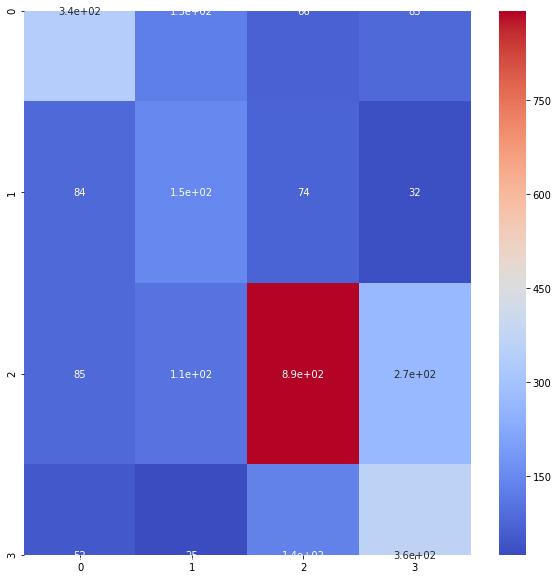

,0,1,2,3
0,342,129,66,83
1,84,147,74,32
2,85,106,891,269
3,52,25,136,365


In [16]:
print(metrics.f1_score(off_df_2.jobflag, off_df_2.preds, average='macro'))
plt.figure(figsize=(10,10))
cnfn_matrix = pd.DataFrame(metrics.confusion_matrix(off_df_2.jobflag, off_df_2.preds))
#cnfn_matrix.index = 
sns.heatmap(cnfn_matrix, annot=True, cmap='coolwarm')
plt.show()
cnfn_matrix

In [17]:
t1_p2 = off_df_2[off_df_2.jobflag==1][off_df_2.preds==2]['text_id'].values.tolist()
t2_p1 = off_df_2[off_df_2.jobflag==2][off_df_2.preds==1]['text_id'].values.tolist()

In [18]:
data = pd.read_csv('../train.csv')

In [19]:
data[data.id.isin(t1_p2)].description.values

array(['Work in a startup-type environment to design and build innovative applications using Automation, Machine Learning/Cognitive Service, business / functional proofs-of-concepts to scalable, production ready solutions across a strategic business group',
       'Strategize in collaboration with functional teams to identify data-driven solutions to ongoing needs across the organization.',
       'Inform bidding strategy and data engineering architecture.',
       'Defining data augmentation pipelines',
       'Develop AI/ML solutions based on NLP techniques such as key phrases extraction, Topics, themes, summarization, entity extraction and Sentiment analysis',
       'Plan and build data-driven banking ecosystem, including ecosystem support models for customer experience and marketing.',
       'Selecting features, building and optimizing classifiers using machine learning techniques',
       'Build API interface for AI/Client models',
       'Builds a deep understanding of the Comp

In [28]:
data[data.id.isin(t2_p1)].description.values

array(['Inform bidding strategy and data engineering architecture.',
       'Defining data augmentation pipelines',
       'Plan and build data-driven banking ecosystem, including ecosystem support models for customer experience and marketing.',
       'Build API interface for AI/Client models',
       'Builds a deep understanding of the Company s products, services, data and customers to facilitate development of personalized and fulfilling experience.',
       'Collaborate with functional leaders to translate business needs into differentiated products & solutions, by driving business case & proforma development.',
       'Communicate analytic solutions to stakeholders and implement improvements as needed to operational systems',
       'Evaluate accuracy and quality of the designed models as well as data sources.',
       'Advise and collaborate in internal partnerships to deliver accurate, available, and accessible data.',
       'Be the interface between the data warehouse and the

In [21]:
data

,id,description,jobflag
0,0,"Executes and writes portions of testing plans,...",2
1,1,Maintain Network Performance by assisting with...,3
2,2,Supports the regional compliance manager with ...,4
3,3,Keep up to date with local and national busine...,1
4,4,Assist with Service Organization Control (SOC)...,4
...,...,...,...
2926,2926,Preparation of reports for operational and man...,3
2927,2927,Line and/or indirect management of up to 20 st...,3
2928,2928,Partner with external agencies as needed,1
2929,2929,"Design, Implement and test software for embedd...",3


In [22]:
test_df2.preds.value_counts()

3    659
4    540
1    383
2    161
Name: preds, dtype: int64

In [23]:
sub = pd.read_csv('../submit_sample.csv', header=None)

In [24]:
sub[1] = test_df2.preds

In [25]:
sub

,0,1
0,2931,3
1,2932,3
2,2933,3
3,2934,1
4,2935,4
...,...,...
1738,4669,1
1739,4670,4
1740,4671,1
1741,4672,4


In [26]:
#sub.to_csv('/Users/abcdm/Downloads/sub_14.csv',  index=False, header=False)

In [27]:
test_preds/(80*25)

array([[0.12838508, 0.31230478, 0.36480007, 0.19451007],
       [0.08310936, 0.15570187, 0.47398954, 0.28719922],
       [0.10580147, 0.14900548, 0.46465474, 0.28053831],
       ...,
       [0.29589718, 0.23231882, 0.29489432, 0.17688969],
       [0.08283854, 0.07187707, 0.36812042, 0.47716396],
       [0.06988015, 0.1236374 , 0.63688098, 0.16960147]])